## Multi classification for the obesity prediction

## Import necessary libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsOneClassifier

## Load dataset

In [8]:
# the obesity prediction dataset
data=pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [9]:
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [12]:
data.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

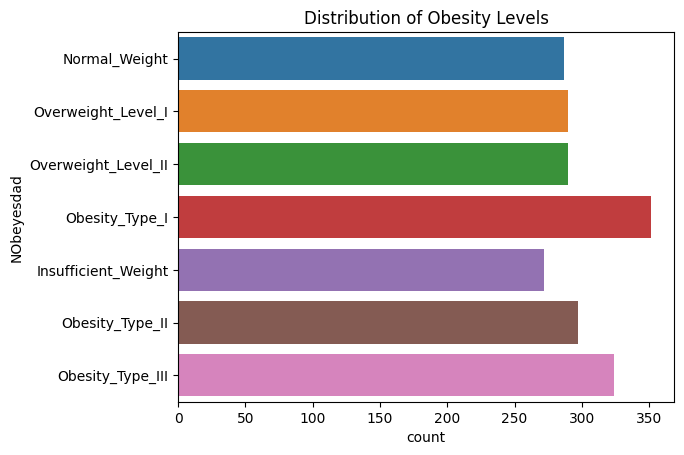

In [13]:
# Distribution of target variable
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()


## EDA

In [14]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

## Preprocessing the data

### Feature scaling
#### Scale the numerical features to standaridize their ranges for better model performance

In [24]:
# standardizing continuous numerical features
continous_columns= data.select_dtypes(include=['float64']).columns.tolist()
scaler=StandardScaler()
scaled_features= scaler.fit_transform(data[continous_columns])




In [25]:
# coverting to a Dataframe
scaled_df=pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continous_columns)
                      )
# combining with the original dataset
scaled_data=pd.concat([data.drop(columns=continous_columns),scaled_df],axis=1)

## One-hot encoding 

### Convert categorical variables into numerical format using one hot encoding

In [29]:
# Identifying categorical columns
categorical_columns= scaled_data.select_dtypes(include=['object']).columns.tolist()

# Exclude target column
categorical_columns.remove("NObeyesdad")

In [34]:
# aplying one-hot encoding
encoder=OneHotEncoder(sparse_output=False ,drop="first")
encoded_features= encoder.fit_transform( scaled_data[categorical_columns])

# Converting to a Dataframe
encoded_df=pd.DataFrame(encoded_features,columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data=pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df])
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Encode the target variable

In [38]:
# Encoding the target variable
prepped_data['NObeyesdad']= prepped_data['NObeyesdad'].astype('category').cat.code

AttributeError: 'CategoricalAccessor' object has no attribute 'code'

## Separate the input and target data

In [39]:
# preparing final dataset
X=prepped_data.drop("NObeyesdad", axis=1)
y= prepped_data['NObeyesdad']

## Model training and evaluation


### Split the data into training and testing subsets

In [40]:
# Splitting data
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.3, random_state=17)